1. Bild laden, croppen und darstellen

w:  3840 , h:  1760


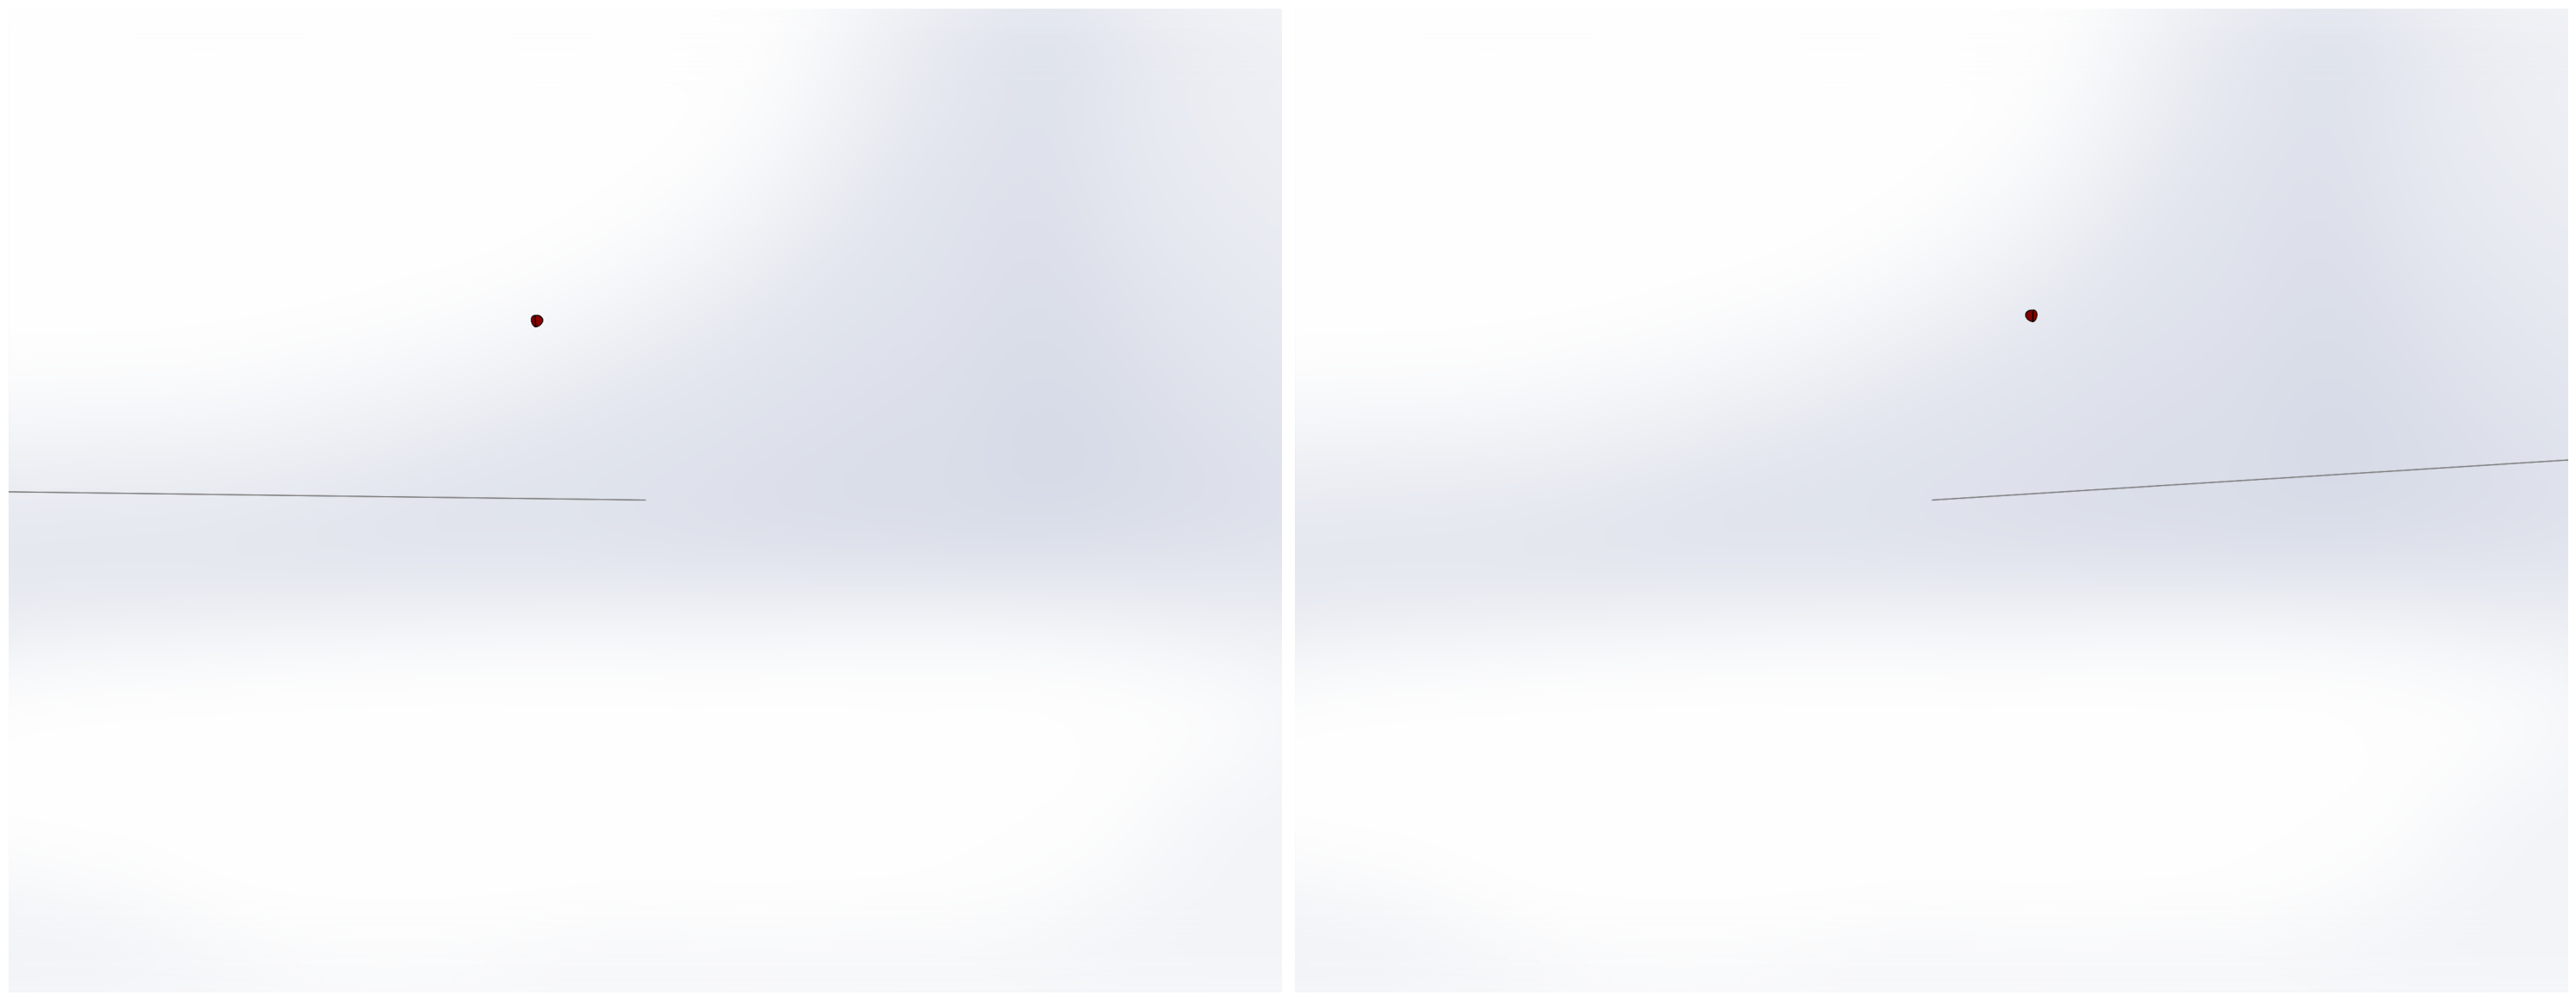

In [1]:
import cv2, glob, os
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
base = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Kamera_Simulationen\Solidworks\Kameraabstand 100mm"
patterns = [os.path.join(base, "**", "*.jpg"),
            os.path.join(base, "**", "*.jpeg"),
            os.path.join(base, "**", "*.png")]
images = []
for pat in patterns:
    images.extend(glob.glob(pat, recursive=True))

img1 = cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(images[1]), cv2.COLOR_BGR2RGB)


Aspectratio = (8.5, 11)
dk = 50         #mm
ak = 13.77      #°
vc1 = np.array([25, 53.59, 200])
vc2 = np.array([-25, 53.59, 200])
h, w, _ = img1.shape
print("w: ", w, ", h: ", h)
def croptoaspect(img, ar):
    w, h, _ = img.shape
    target_ratio = ar[0] / ar[1]  # width / height
    # Center-crop to target aspect ratio
    if (w / h) > target_ratio:
        # too wide -> crop width
        new_w = int(h * target_ratio)
        x0 = (w - new_w) // 2
        y0 = 0
        x1 = x0 + new_w
        y1 = h
    else:
        # too tall -> crop height
        new_h = int(w / target_ratio)
        x0 = 0
        y0 = (h - new_h) // 2
        x1 = w
        y1 = y0 + new_h

    return img[x0:x1, y0:y1]
img1_cropped, img2_cropped = croptoaspect(img1, Aspectratio), croptoaspect(img2, Aspectratio)
h, w, _ = img1.shape
get_ipython().run_line_magic('matplotlib', 'inline')
plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
axes[0].imshow(img1_cropped)
axes[0].axis('off')
axes[1].imshow(img2_cropped)
axes[1].axis('off')
plt.tight_layout()
plt.show()


2. Rote pixel ermitteln und den schwerpunkt in Pixelkoordinaten berechnen

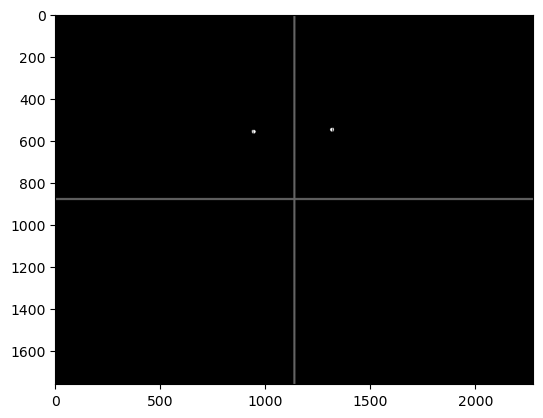

(558.921052631579, 944.390350877193) (549.490990990991, 1316.3198198198197)


In [2]:
from scipy import ndimage

#Bereich für die Roten Pixel definieren
lower_red = np.array([100, 0, 0])
upper_red = np.array([255, 80, 80])

#Maske erstellen
mask1 = cv2.inRange(img1_cropped, lower_red, upper_red)
mask2 = cv2.inRange(img2_cropped, lower_red, upper_red)
#Schwerpunkt ermitteln
com1 = ndimage.center_of_mass(mask1)
com2 = ndimage.center_of_mass(mask2)

#darstellen der masken in einem bild
combined_masks = np.bitwise_or(mask1, mask2)
H, W = mask1.shape  # Höhe, Breite
combined_masks[int(H/2)-5:int(H/2)+5, :] = 100
combined_masks[:, int(W/2)-5:int(W/2)+5] = 100
plt.imshow(combined_masks, cmap='gray')
plt.show()
print(com1, com2)

3. Funktionen für die Rotationsmatrix und kameramatrix

In [3]:
#Rotationsmatrix für gegebenen kameravektor
def getR(vc):
    up = np.array([0, 1, 0], dtype=float)
    origin = np.array([0, 0, 0], dtype=float)

    # Kamera schaut zum Ursprung
    zc = (origin - vc) / np.linalg.norm(origin - vc)

    # Rechte-Hand-System aufspannen
    xc = np.cross(up, zc)
    xc /= np.linalg.norm(xc)

    yc = np.cross(zc, xc)

    # Spalten = Achsen im Welt-KS
    R = np.column_stack((-xc, -yc, zc))
    return R
def PixeltoCameraVector(com, H, W):
    """

    :param com: liste mit 2 einträgen [0]: Vertikal, [1]: Horizontal
    :param H:   integer für Bildhöhe
    :param W:   integer für Bildbreite
    :return:    np.array mit xyz
    """
    thetay = np.deg2rad(26.99)
    thetax = 2 * np.arctan(np.tan(thetay / 2) * W / H)
    #fokale längen
    fx = W / (2 * np.tan(thetax / 2))
    fy = H / (2 * np.tan(thetay / 2))
    #Bildmittelpunkte
    cx = W / 2
    cy = H / 2
    #Kameramatrix
    K = np.eye(3)
    K[0, 0] = fx
    K[1, 1] = fy
    K[0, 2] = cx
    K[1, 2] = cy
    #Schwerpunktsvektor
    sv = np.array([com[1], com[0], 1])
    vector = np.linalg.inv(K) @ (sv)
    vector_norm = vector / np.linalg.norm(vector)
    return vector_norm
def getminAbstand(p1, d1, p2, d2):
    n = np.cross(d1, d2)                # Kreuzprodukt
    zähler = abs(np.dot(p1 - p2, n))    # Skalarprodukt!
    nenner = np.linalg.norm(n)          # Norm vom Kreuzprodukt
    if nenner < 1e-12:                  # Spezialfall: fast parallel
        return np.linalg.norm(np.cross(p1 - p2, d1)) / np.linalg.norm(d1)
    return zähler / nenner
def getminAbstandPunkt(p1, d1, p2, d2):
    # am besten Richtungen normieren, damit stabiler
    d1 = d1 / np.linalg.norm(d1)
    d2 = d2 / np.linalg.norm(d2)

    r = p1 - p2
    a = np.dot(d1, d1)
    b = np.dot(d1, d2)
    c = np.dot(d2, d2)
    d = np.dot(d1, r)
    e = np.dot(d2, r)

    denom = a * c - b * b
    if abs(denom) < 1e-12:
        # Spezialfall: Richtungen (fast) parallel
        # -> Projektion von p1 auf Linie 2
        t = 0.0
        s = np.dot(d2, r) / c
    else:
        t = (b * e - c * d) / denom
        s = (a * e - b * d) / denom

    q1 = p1 + t * d1
    q2 = p2 + s * d2
    q = 0.5 * (q1 + q2)   # Mittelpunkt der kürzesten Verbindung

    return q
def rotz(p, winkel):
    R_z = np.eye(3)
    R_z[0, 0] = np.cos(np.deg2rad(winkel))
    R_z[0, 2] = np.sin(np.deg2rad(winkel))
    R_z[2, 0] = -np.sin(np.deg2rad(winkel))
    R_z[2, 2] = np.cos(np.deg2rad(winkel))
    return R_z @ p
H, W, _ = img1_cropped.shape
PixeltoCameraVector(com1, H, W)
print(img1_cropped.shape)

(1760, 2277, 3)


Ausprobieren: verschiedenene Vektoren mit kamera rotationsmatrix mulitplizieren:

In [5]:
plt.close("all")
Laserpunkt = np.array([0, 25, 35.36])
#Kameravektoren
VC1 = np.array([50, 53.59 , 200])
VC2 = np.array([-50, 53.59 , 200])
dcam1 = VC1 / np.linalg.norm(VC1)
dcam2 = VC2 / np.linalg.norm(VC2)

#Kamerarays
R1B = VC1
R1D = getR(VC1) @ PixeltoCameraVector(com1, H, W)

R2B = VC2
R2D = getR(VC2) @ PixeltoCameraVector(com2, H, W)
s = getminAbstandPunkt(R1B, R1D, R2B, R2D)

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1,1,1])

t = np.linspace(0.0, 1.0, 2)

#Achsen gleich skalieren
def set_axes_equal(ax):
    '''Gleiche Skalierung für alle 3 Achsen'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range, x_middle + max_range])
    ax.set_ylim3d([y_middle - max_range, y_middle + max_range])
    ax.set_zlim3d([z_middle - max_range, z_middle + max_range])



#Ausrichtung wie in solidworks/3d kamerakonventionen
ax.view_init(elev=90, azim=-90)

def plot_ray(ax, base, direction, scale=300, label=None, color=None):
    """
    Plottet eine Gerade r(t) = base + t * direction im 3D-Plot.

    Parameters
    ----------
    ax : matplotlib 3D axis
    base : array-like, shape (3,)
        Startpunkt der Geraden
    direction : array-like, shape (3,)
        Richtungsvektor (muss nicht normiert sein)
    scale : float
        Länge der Geraden
    label : str
        Legendenbeschriftung
    color : str oder None
        Farbe für die Linie (optional)
    """
    base = np.asarray(base, dtype=float)
    direction = np.asarray(direction, dtype=float)
    direction = direction / np.linalg.norm(direction)  # normieren

    pts = np.array([base, base + scale * direction])
    ax.plot(pts[:,0], pts[:,1], pts[:,2], label=label, color=color)

def plotvec(v, label):
    ax.plot((0, v[0]), (0, v[1]), (0, v[2]), label=label)
plotvec(VC1, "VC1")
plotvec(VC2, "VC2")
"""plotvec(100*(getR(VC1) @ np.array([0, 1, 0])), "Kamera1 y-Achse")
plotvec(100*(getR(VC1) @ np.array([1, 0, 0])), "Kamera1 x-Achse")
plotvec(100*(getR(VC1) @ np.array([0, 0, 1])), "Kamera1 z-Achse")"""


plotvec(getR(VC1) @ PixeltoCameraVector(com1, H, W), "kameraray1")
plotvec(getR(VC2) @ PixeltoCameraVector(com2, H, W), "kameraray1")
plot_ray(ax, VC1, R1D)
plot_ray(ax, VC2, R2D)

print("Messungenauigkeit: ", np.linalg.norm(Laserpunkt- s))
ax.scatter(s[0], s[1], s[2],color='blue',  s=5, label="scanpunkt")
s=rotz(s, 180)
ax.scatter(s[0], s[1], s[2],color='blue',  s=5, label="scanpunkt um 90° gedreht")

ax.scatter(Laserpunkt[0], Laserpunkt[1], Laserpunkt[2],color='red',  s=5, label="Laser Punkt")
def plotcube():
    # Ursprungswürfel-Koordinaten
    x = [-25, 25]
    y = [0, 50]
    z = [-25, 25]

    # Alle Eckpunkte generieren
    cube_points = np.array([[xi, yi, zi] for xi in x for yi in y for zi in z])

    # Linienpaare für die Würfelkanten
    edges = [
        (0,1), (0,2), (0,4),
        (3,1), (3,2), (3,7),
        (5,1), (5,4), (5,7),
        (6,2), (6,4), (6,7),
        (3,6)
    ]

    # Würfel plotten
    for i,j in edges:
        ax.plot(
            [cube_points[i,0], cube_points[j,0]],
            [cube_points[i,1], cube_points[j,1]],
            [cube_points[i,2], cube_points[j,2]],
            color="gray"
        )
plotcube()
# Axes labels and legend
set_axes_equal(ax)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


<IPython.core.display.Javascript object>

Messungenauigkeit:  0.8702110266461255


In [78]:
thetay = 26.99
print(np.tan(np.deg2rad(thetay)/2))
print(np.tan(np.deg2rad(thetay/2))
)

0.2399864647030856
0.2399864647030856
